In [9]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import os

## Függvények

### Vizualizációt segítők

In [10]:
def plot_2d(mx, title):
    plt.figure(figsize=(4, 3))
    plt.imshow(mx, cmap='viridis', interpolation='nearest', aspect='auto')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Freq')
    plt.show()

In [11]:
# a bucket_func vizualizalasara: 0-t rak oda ahol nincs maximum pozicio, 1-et oda ahol van
def visualize_bucket(input_mx, x, y): # maximumok listaja, a kimeneti matrix hossza, magassaga
    output_mx = [[0] * x for _ in range(y)]  
    for i in range(y):
        for j in range(len(input_mx[0])):
            output_mx[i][input_mx[i][j]] = 1
    return np.fliplr(np.rot90(output_mx,3)) # rotates by 90 deg, 3 times

In [12]:
# csak hogy ne 3 sorban kellejen inicializalni minden egyes file beolvasasakor
def visuals_from_file(file, bucket_n):
    mel = spect_from_file(file)
    result = bucket_func(mel, bucket_n)
    result_view = visualize_bucket(result, len(mel), len(mel[0]))
    return mel, result, result_view

### Pipeline

In [13]:
def spect_from_file(file): # beolvasott .wav filebol spektrogramot ad vissza 500hz es 5000hz kozti frekvencia bin-ek megtartasaval
    scale, sr = librosa.load(file)
    spectrogram = librosa.stft(y=scale, n_fft=2048, hop_length=512)
    log_spectrogram = librosa.power_to_db(np.abs(spectrogram))
    return log_spectrogram[80:-550]

In [14]:
# n_buckets db vodorre bontja a spektrogram oszlopait, es vissza adja a vodrokon beluli maximumok oszlopon beluli helyenek listajat 
def bucket_func(input_mx, n_buckets): # parameterek: spektrogram matrixa, ahany vodorben akarjuk meghatarozni a maximumokat
    input_mx = input_mx[:(len(input_mx) - (len(input_mx) % n_buckets))]
    input_mx = list(zip(*input_mx))
    output_mx = []
    for row in input_mx:
        output_mx_row = []
        sublists = [row[i:i+len(row)//n_buckets] for i in range(0, len(row), len(row)//n_buckets)]
        for bucket in sublists:
            output_mx_row.append((sublists.index(bucket)*len(row)//n_buckets) + bucket.index(max(bucket)))
        output_mx.append(output_mx_row)
    return output_mx

In [15]:
# A bucket_func kimenetehez kell, atirja olyan alakra, ahol a pontok [x, y] koordinatak alapjan vannak eltarolva 
def get_coordinate_values(mx):
    output_mx = []
    for col_n in range(len(mx)):
        for i in range(len(mx[col_n])):
            output_mx.append([col_n, mx[col_n][i]])
    return(np.array(output_mx))

In [16]:
# Ez generalja a fingerprinteket (azaz minden pontbol kiszamolja a kovetkezo 'size' db pont tavolsagait, es az lesz egy fingerprint)
def calc_distance_dict(mx, size):
    output_dict = {}
    for i in range(len(mx)-(size+1)):
        output_dict_key = ''
        for j in range(1, size+1, 1):
             output_dict_key =  output_dict_key + str(abs(mx[i+j][0] - mx[i][0])) + str(abs(mx[i+j][1] - mx[i][1]))
        #print(output_dict_key)
        output_dict.update({int(output_dict_key): None})
    return output_dict 

In [26]:
# A pipeline: egymasutan rakja a fonti fuggvenyeket
def pipeline_dict(file_name):
    op = spect_from_file(file_name) # 500db frekvencia tartomany (sor)
    op = bucket_func(op, 5) # 5db maximum egy oszlopban
    op = get_coordinate_values(op) # atirja jo formatumra
    op = calc_distance_dict(op, 7) # kiszamolja a fingerprinteket minden pontra, ugy hogy 8db utana jovot nez
    return op

In [36]:
# osszehasonlitja dict_in-t (ami egy hashmap, fingerprintekbol), a lent emlitett mappaban talalhato .wav-ok fingerprint-jeivel
def run_thru_db(dict_in): 
    names = []
    folder_path = os.path.join('onlab', 'dataset') # Az onlab/dataset mappabol beolvassa a az osszes .wav file-t
    data_files = os.listdir(folder_path)
    for file in data_files:
        counter = 0
        grew = False
        file_path = os.path.join(folder_path, file)
        dict_song = pipeline_dict(file_path)
        for key in dict_in.keys():
            if key in dict_song:
                counter += 1
                if file not in names:
                    names.append(file)
                    grew = True
        if grew is True:
            names.append(counter)
    return names

## Bemutatas

### Spektrogram fájlbol (Weekend - Blindig light részlet kb. 5mp)

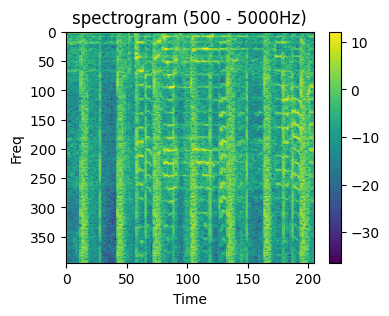

In [29]:
spect_test_1 = spect_from_file('onlab/test_wavs/intest1.wav')
plot_2d(spect_test_1, 'spectrogram (500 - 5000Hz)')

### A spektrogram csúcspontjai vizualizálva, 6db vödör esetén

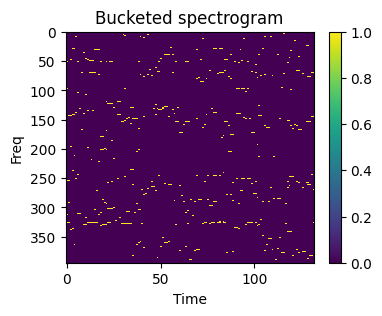

In [30]:
spect_1, result_1, result_1_view = visuals_from_file("onlab/test_wavs/test1.wav", 6)
plot_2d(result_1_view, 'Bucketed spectrogram')

### Az ezekbol keszitett elso 5 db ujjlenyomat kiiratva

In [31]:
fingerprints = pipeline_dict("onlab/test_wavs/test1.wav")
print(list(fingerprints)[:5])

[46011202620266111471111, 6602160220147111651157, 15001541113165111911163, 41263121511511591132265, 1267121911551631922692207]


### Teszteles adatbázison:
6 db 5 mp hosszú stúdió mikrofonnal felvett teszt fájl végig futtatása a a 18 elemű teljes zeneszámok ujjlenyomatait \
tartalmazó adathalmazon, visszaadva hogy melyik zeneszámhoz tartozó és hány db egyezést talált: \
['Zeneszám', db] formában

In [38]:
## Itt fut a kod
testfolder_path = os.path.join('onlab', 'gep_hangok') ## Ebbol a mappabol kiolvassa a 
test_files = os.listdir(testfolder_path)
for file in test_files: # vegig megy az osszes fileon a fenti mappabol
    file_patht = os.path.join(testfolder_path, file)
    dict_test_song = pipeline_dict(file_patht) # kiszamolja a fingerprintjet, a teszt hangnak, majd a lejjebbi sorban osszehasonlitja az adatbazissal
    print(str(file) + ': ' + str(run_thru_db(dict_test_song))) # Kiirja hogy melyik filehoz, hanyadik szamu zenet koti az oblab/dataset mappabol

Counting Stars test.wav: ['OneRepublic - Counting Stars.wav', 23]
Human test.wav: ["Rag'n'Bone Man - Human.wav", 3]
Save Your Tears test.wav: ['Adele - Easy On Me.wav', 4, 'Adele - Rolling in the Deep.wav', 6, 'The Weeknd - Save Your Tears.wav', 82]
Shallow test.wav: ['Lady Gaga, Bradley Cooper - Shallow.wav', 33]
Sugar test.wav: ['Adele - Easy On Me.wav', 1, 'Maroon 5 - Sugar.wav', 2, "Rag'n'Bone Man - Human.wav", 2, 'The Weeknd - Blindig Lights.wav', 1]
Take Me To Church test.wav: ['Horzier - Take me to church.wav', 2]
